### College of Computing and Informatics, Drexel University
### INFO 213: Data Science Programming II
---

## Final Project

## Project Title: Rossmann Store Sales Forecast

## Student(s): Junkai Ge

## Date: 03/16/2024
---

Project Background：

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.

## 1. Load Data

In [177]:
import pandas as pd
import numpy as np
import xgboost as xgb
import missingno as msno
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
store = pd.read_csv('/content/store.csv')

<ipython-input-120-d4b947cec00d>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/train.csv')


### The results of the following operations show that there are missing values in both test.csv and store.csv, and we can preprocess accordingly.

In [121]:
train.info(), test.info(), store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date     

(None, None, None)

## 2. EDA



### Exploratory Data Analysis

<Axes: >

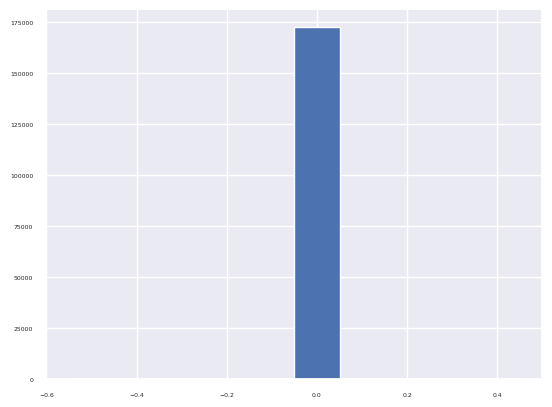

In [122]:
train.loc[train.Open==0].Sales.hist(align='left')

Finding: when the store is closed, the daily sales are necessarily 0.

The skewness of Sales is 1.5939220392699809


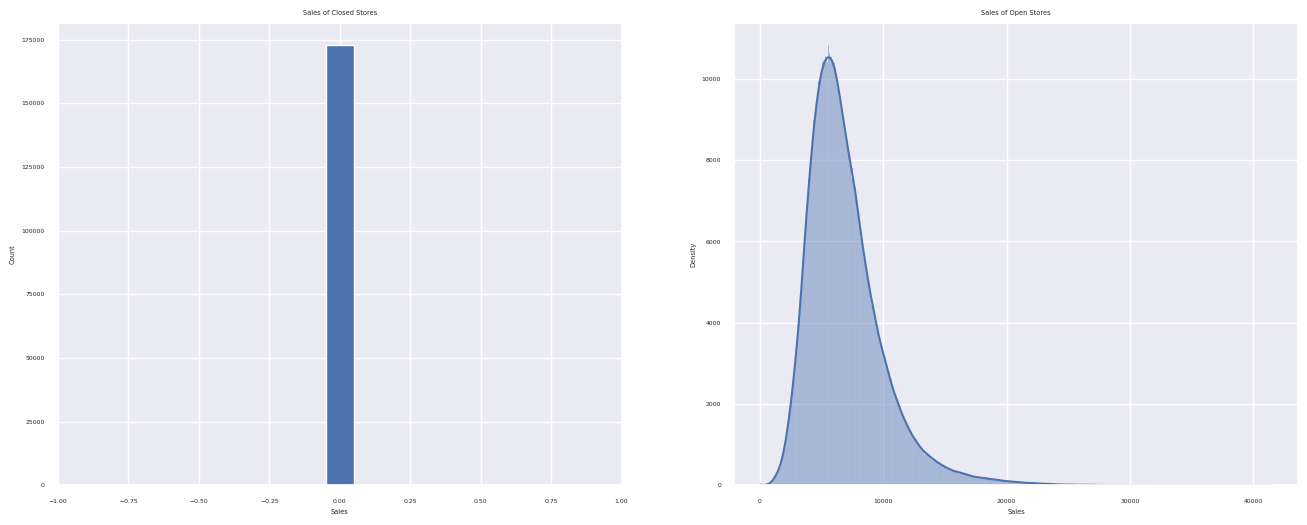

In [123]:
fig = plt.figure(figsize=(16,6))

# Sales of Closed Stores
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Count')
ax1.set_title('Sales of Closed Stores')
plt.xlim(-1,1) # Assuming this is relevant for your data; you might need to adjust this.
train.loc[train.Open==0].Sales.hist(align='left', ax=ax1)

# Sales of Open Stores with histplot
ax2 = fig.add_subplot(122)
ax2.set_xlabel('Sales')
ax2.set_ylabel('Density')
ax2.set_title('Sales of Open Stores')
sns.histplot(train.loc[train.Open!=0].Sales, kde=True, ax=ax2)  # kde=True adds the density line

# Calculating skewness
skewness = train.loc[train.Open!=0].Sales.skew()
print('The skewness of Sales is {}'.format(skewness))

After removing the data when the store is closed, re-plot the daily sales distribution when the store is opened. It can be found that the daily sales show an obvious skewed distribution, with a skewness of about , which is much larger than , and we will consider making preprocessing adjustments to the data distribution.

In the following, we only use the data when the store is open (Open!=0 ) for training.

In [124]:
train = train.loc[train.Open != 0]
train = train.loc[train.Sales > 0].reset_index(drop=True)
train.shape

(844338, 9)

### 2.1 Line graph

We have used matplotlib.pyplot to plot the sales data of the store with serial number from January 2013 to 2015 months.

<Axes: title={'center': 'The Sales Data In Store 1'}, xlabel='Date'>

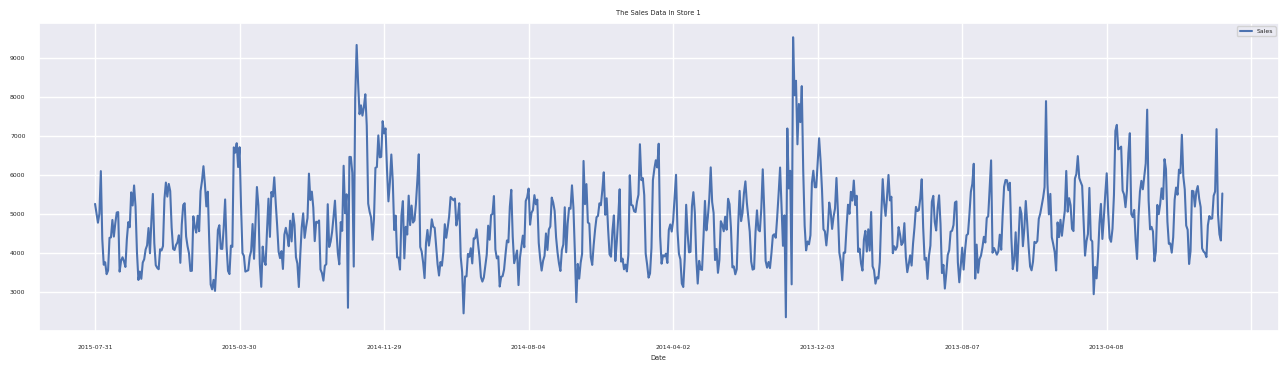

In [125]:
train.loc[train['Store']==1,['Date','Sales']].plot(x='Date',y='Sales',title='The Sales Data In Store 1',figsize=(16,4))

View the graph of sales data from January 2013 to month 2015 for the store with serial number 1 to get a visual sense of the overall character of the change in the data.

### 2.2 Plot of univariate distribution

<Axes: xlabel='Sales', ylabel='Count'>

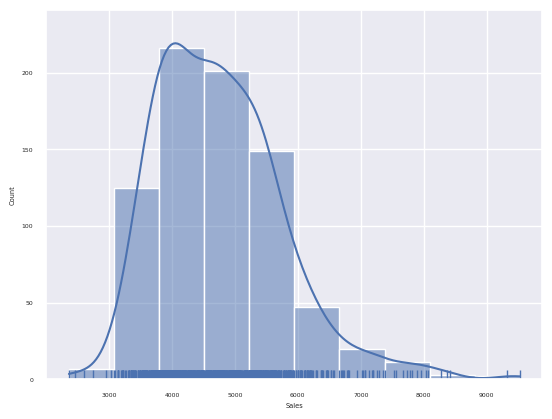

In [126]:
sns.histplot(train.loc[train['Store']==1, 'Sales'], bins=10, kde=True)

# Add a rug plot
sns.rugplot(train.loc[train['Store']==1, 'Sales'])

The data distribution graph shows that the data is mainly distributed in the sales of 4000-6000, and the distribution of data ranges from 2000-10000, which is basically in line with the overall normal distribution.

### 2.3 Joint Distribution Plots of Binary Variables

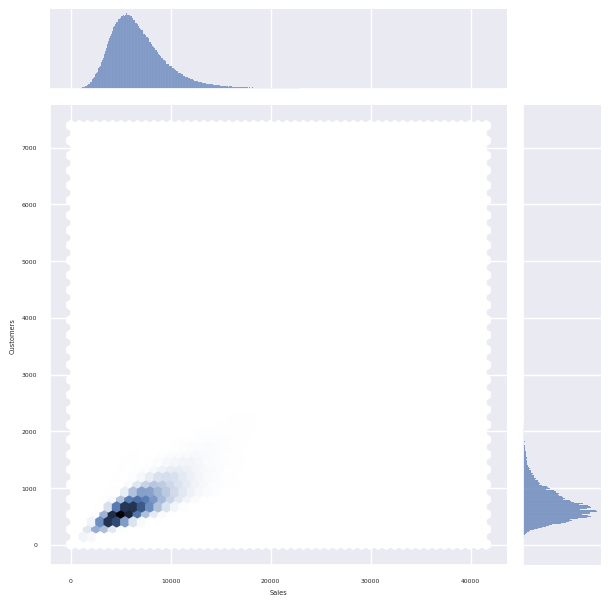

In [127]:
sns.jointplot(x=train["Sales"], y=train["Customers"], kind="hex")

Binary variable correlation analysis plotting can help us visualize the correlation between two columns of data, in the above figure we can easily observe that there is a certain linear relationship between customer flow and sales flow.

### 2.4 Heat map

Applied to the corr() function in Pandas, the correlation between each column of data is calculated. Here the correlation is the Pearson correlation coefficient

In [128]:
train_corr = train.corr(numeric_only=True)

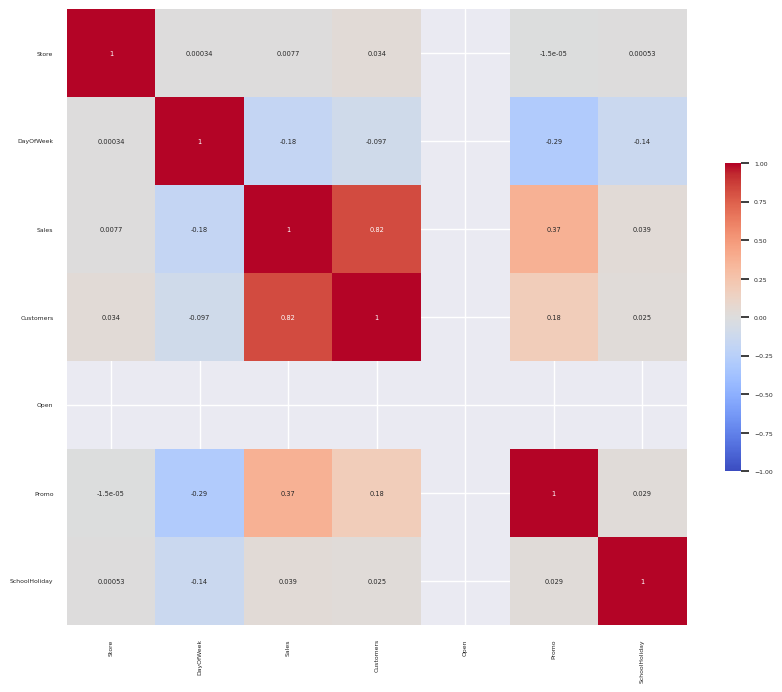

In [129]:
# Setting the canvas size and font size
plt.figure(figsize=(10, 8))
sns.set(font_scale=0.4)

# Generate heat maps, adjust label rotation and color scale size
ax = sns.heatmap(
    train_corr,
    annot=True,
    vmin=-1.0,
    vmax=1.0,
    center=0,
    cmap='coolwarm',
    cbar_kws={"shrink": 0.5}
)

# Rotating label
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

The above graph shows that many of the parameters have some positive or negative correlation with each other, meaning that there is some correlation between these data, which means that we can classify or regress these data using machine learning models.

## 3. Data Preprocessing


In [130]:
## Missing information in training set: none missing
train[train.isnull().values==True]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [131]:
## Missing information for the test set
test[test.isnull().values==True]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


<Axes: >

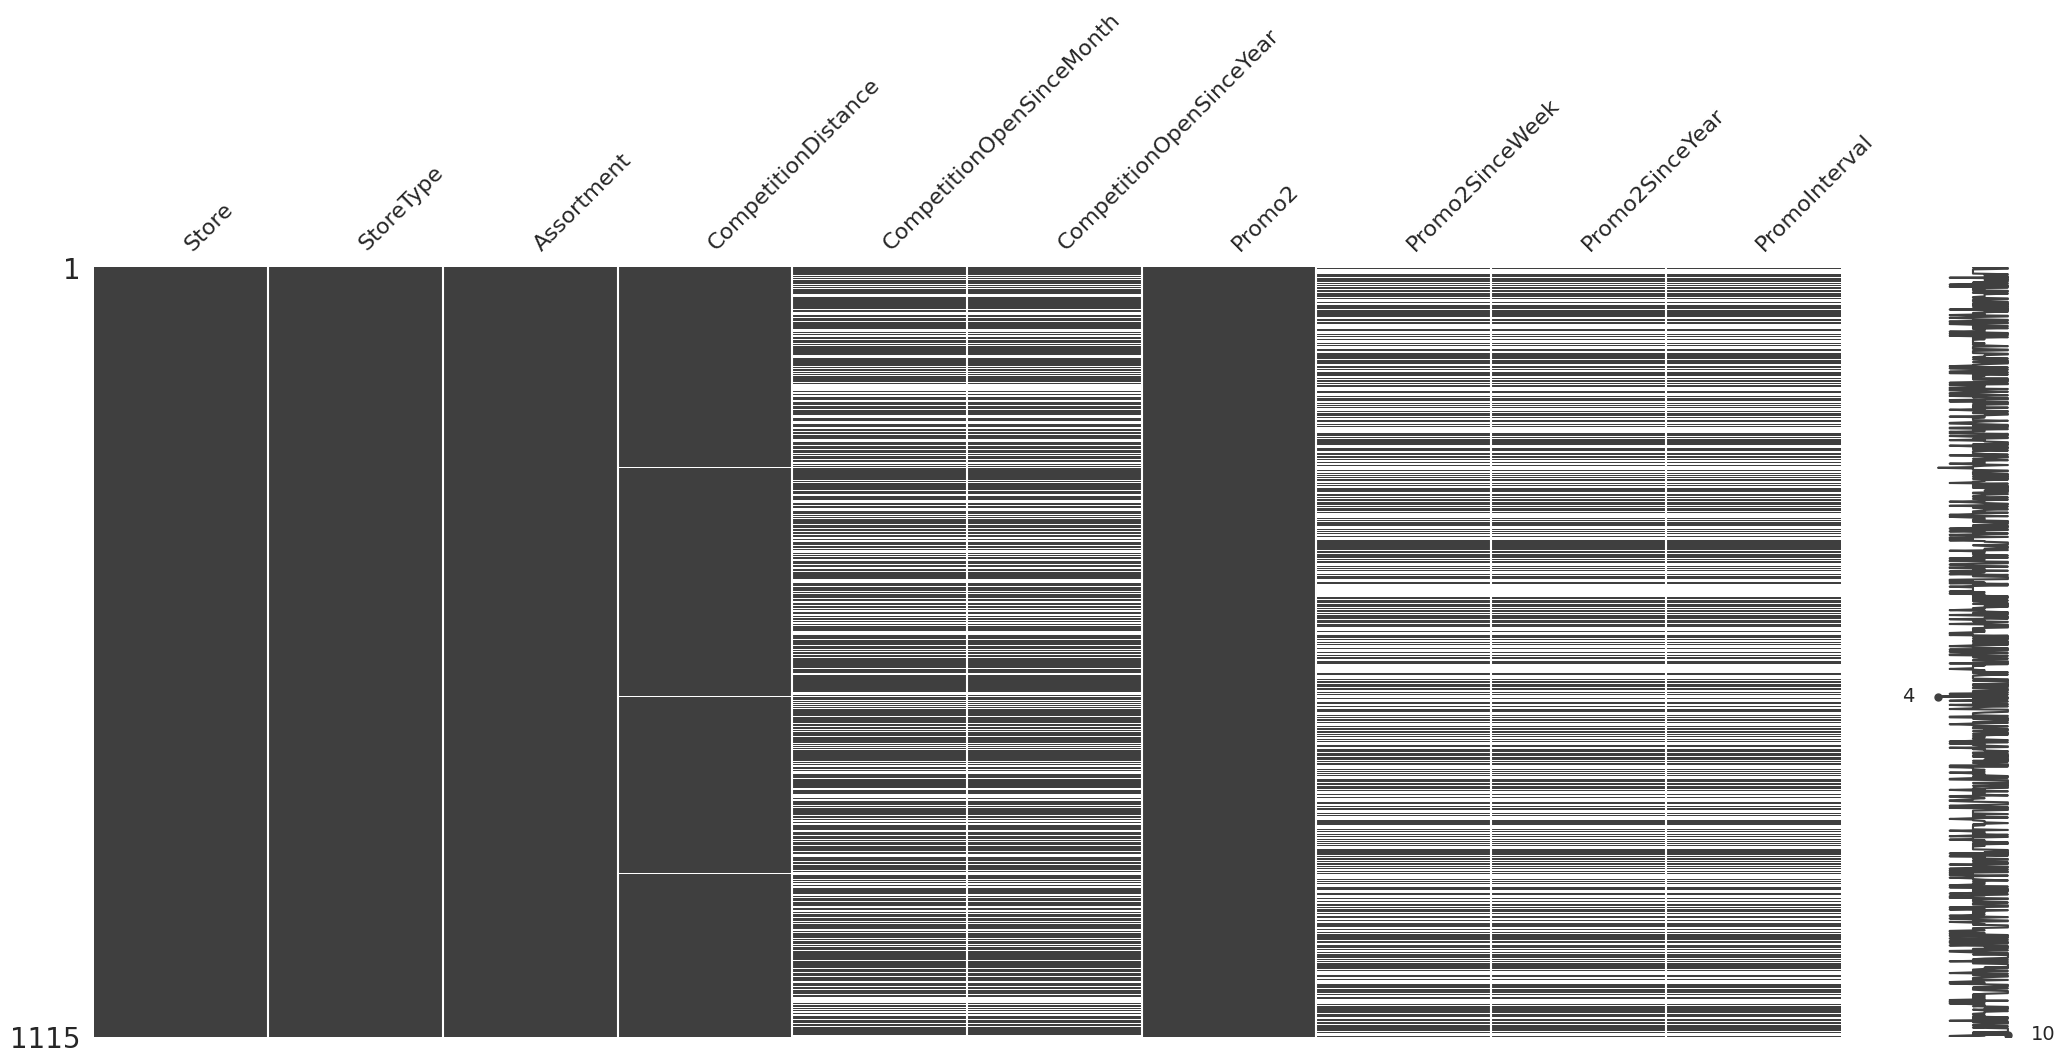

In [132]:
## Missing information from store
msno.matrix(store)

Both test.csv and store.csv have missing values, which we will process and merge the features:

In [133]:
## All stores in the default test are open for business
test.fillna(1,inplace=True)
## Missing values in CompetitionDistance were filled in using median
store.CompetitionDistance = store.CompetitionDistance.fillna(store.CompetitionDistance.median())
## Add 0 to all other missing values
store.fillna(0,inplace=True)

In [134]:
## Feature merging
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [135]:
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
5,1,6,2015-07-25,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
6,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
7,1,4,2015-07-23,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
8,1,3,2015-07-22,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
9,1,2,2015-07-21,3558,469,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## 4. Feature Engineering

### 4.1 Feature extraction function

In [136]:
def build_features(features, data):
    #  Features for direct use
    features.extend(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'StateHoliday', 'StoreType', 'Assortment',
                     'SchoolHoliday', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])
    # Temporal features, extracting information such as the day of the week, month and year
    features.extend(['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    # Update WeekOfYear extraction to avoid FutureWarning
    data['WeekOfYear'] = data.Date.dt.isocalendar().week

    # 'CompetitionOpen' and 'PromoOpen' feature calculations
    features.extend(['CompetitionOpen', 'PromoOpen'])
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)

    # 'IsPromoMonth' feature calculation
    features.append('IsPromoMonth')
    month2str = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval:
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    # Conversion of character features to numbers
    mappings = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data['StoreType'] = data['StoreType'].astype(int)
    data['Assortment'] = data['Assortment'].astype(int)
    data['StateHoliday'] = data['StateHoliday'].astype(int)


### 4.2 Feature extraction

In [137]:
## Handling Date for easy feature extraction
train.Date = pd.to_datetime(train.Date, errors='coerce')
test.Date = pd.to_datetime(test.Date, errors='coerce')
## Use the features array to store the features used
features = []
## Feature extraction for train and test
build_features(features, train)
build_features([], test)

print(features)

['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'StateHoliday', 'StoreType', 'Assortment', 'SchoolHoliday', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


## 5. Model Selection And Evaluation

### 5.1 Define the evaluation criterion function

Since continuous values need to be predicted, a regression model is required. I chose to use RMSPE.The formula for RMSPE is:
![image.png](Since continuous values need to be predicted, a regression model is required. I chose to use RMSPE.The formula for RMSPE is:
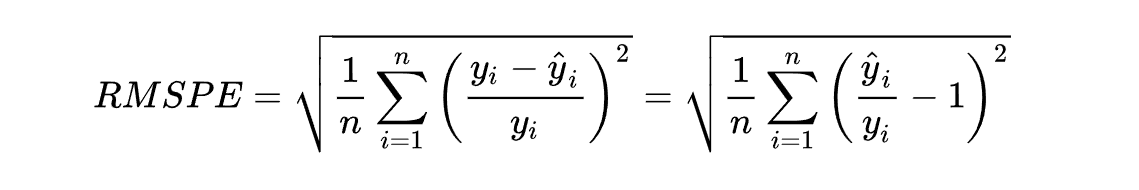
yi: represents the store's true sales for the day.

(y.hat)i: represents corresponding forecasted sales.

n: represents the number of samples.

In [138]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return rmspe
def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return "rmspe", rmspe
def neg_rmspe(yhat, y):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return -rmspe

### 5.2 Decision Tree Model

We construct a regression tree model as the base model for modeling and evaluation. We directly use SKLearn's DecisionTreeRegressor for the regression tree, with folded cross-validation and grid search for tuning, the main hyperparameter is the maximum depth of the tree max_depth

In [139]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor


regressor = DecisionTreeRegressor(random_state=2)
cv_sets = ShuffleSplit(n_splits=5, test_size=0.2)
params = {'max_depth': range(10, 40, 2)}
scoring_fnc = make_scorer(neg_rmspe)
grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)
grid = grid.fit(train[features], np.log1p(train['Sales']))
DTR = grid.best_estimator_


In [140]:
## Show optimal hyperparameters
DTR.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 28,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2,
 'splitter': 'best'}

Generate final forecast based on regression tree model

In [176]:
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(DTR.predict(test[features]))})
submission.to_csv("Decision_tree_model_result.csv", index=False)

### 5.3. XGBoost Tuning

In [ ]:
'''
# Starting parameters
 params = {'objective': 'reg:linear',
           'eta': 0.01,
           'max_depth': 11,
           'subsample': 0.5,
           'colsample_bytree': 0.5,
           'silent': 1,
           'seed': 1
           }
 num_trees = 10000
'''

In [ ]:
'''
# Second parameters adjustment
 params = {'objective': 'reg:linear',
           'eta': 0.3,
           'max_depth': 10,
           'subsample': 0.9,
           'colsample_bytree': 0.7,
           'silent': 1,
           'seed': 1301
           }
 num_trees = 10000
Conclution: Excessive learning rate and reduced effectiveness
'''

In [162]:
## Third parameter adjustment
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.85,
          "colsample_bytree": 0.4,
          "min_child_weight": 6,
          "silent": 1,
          "thread": 1,
          "seed": 1301
          }
num_trees = 1200
## Moderate step size, fast convergence, excellent results

In [163]:
from sklearn.model_selection import KFold

def K_Fold_split(K, fold, data):
    '''

    param K: The number of parts to divide the dataset into. For example, ten times ten, take K=10

    param fold: The number of folds to take. If you want to take the 5th fold then fold=5

    param data: data to be chunked

    return: the training set and test set of the corresponding fold.
    '''

    kf = KFold(n_splits=K)
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        if i == fold:
            X_train, X_test = data.iloc[train_index], data.iloc[test_index]
            return X_train, X_test
    return None, None  # If fold is out of range, return None

# Splitting the data into train and test sets using K-Fold cross validation
X_train, X_test = K_Fold_split(10, 5, train)

# Creating DMatrix objects for train and validation sets
dtrain = xgb.DMatrix(X_train[features], np.log1p(X_train['Sales']))
dvalid = xgb.DMatrix(X_test[features], np.log1p(X_test['Sales']))

# Creating DMatrix object for the test set
dtest = xgb.DMatrix(test[features])

# Creating a watchlist for training and evaluation
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

# Training the XGBoost model
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=False)


/usr/local/lib/python3.10/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:36:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:36:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent", "thread" } are not used.

  warnings.warn(smsg, UserWarning)


In [164]:
# Predicting sales values for the test set using the trained XGBoost model
test_probs = gbm.predict(xgb.DMatrix(test[features]), iteration_range=(0, gbm.best_iteration + 1))

# Creating a boolean mask to identify predicted sales values less than 0
indices = test_probs < 0

# Setting predicted sales values to 0 where they are less than 0
test_probs[indices] = 0

# Creating a DataFrame for submission with 'Id' column from the test data and predicted sales values
# Converting predicted sales values back to their original scale using np.expm1
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(test_probs)})


submission.to_csv("xgboost.csv", index=False)

## 6. Visualization

Shows predicted data before and after optimization, the smaller the value the closer it is to the real data. The source of the obtained data results is the official Kaggle website.
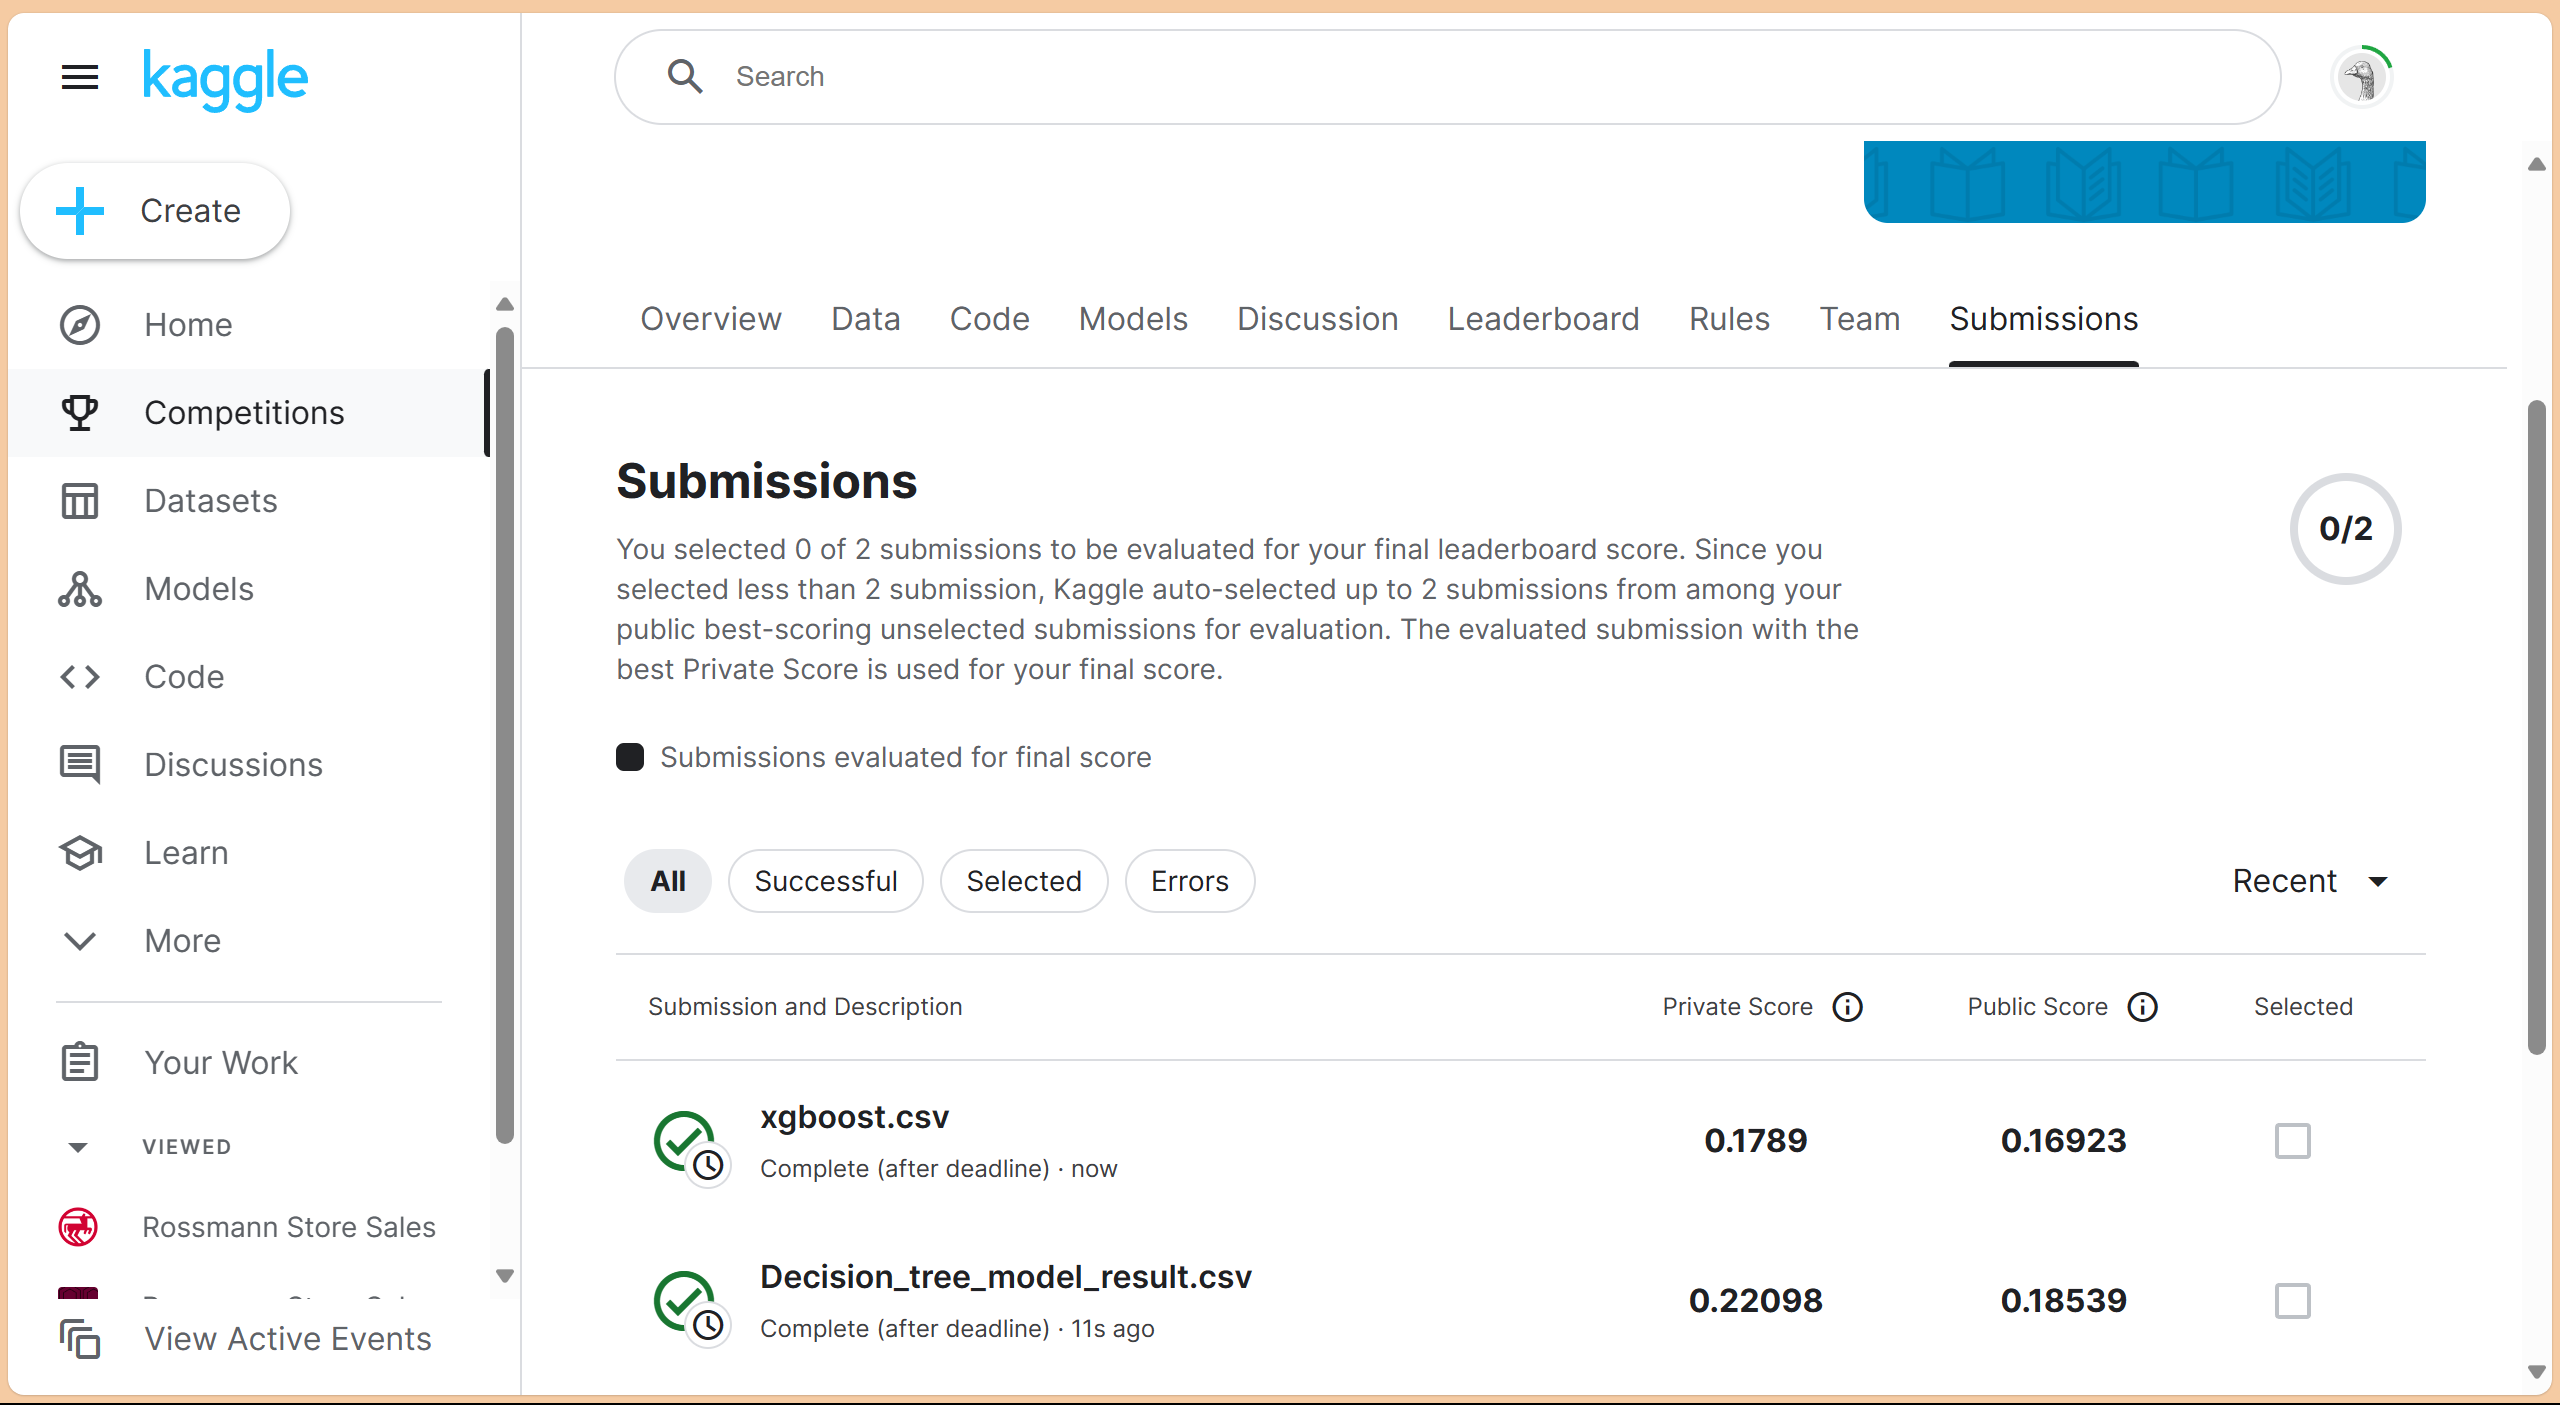

### 6.1 Comparison Of Results

In [168]:
df = pd.DataFrame([[0.22098, 0.18539], [0.1789, 0.16923]],
                 index=['Decision tree', 'XGBoost'],
                 columns=['Private Score', 'Public Score'])
df

,Private Score,Public Score
Regression tree,0.22098,0.18539
XGBoost,0.17890,0.16923


### 6.2 Private Score Changes

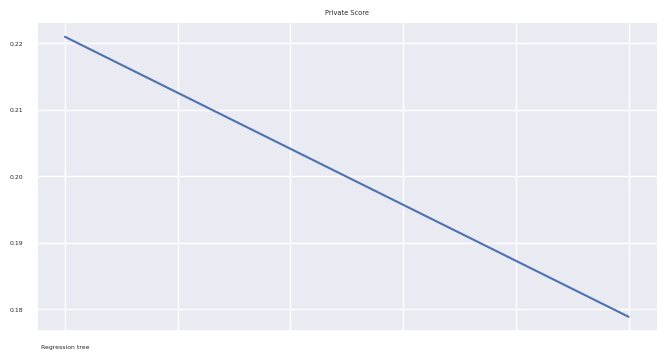

In [175]:
from matplotlib import pyplot as plt
df['Private Score'].plot(kind='line', figsize=(8, 4), title='Private Score')
plt.gca().spines[['top', 'right']].set_visible(False)

### 6.3 Public Score Changes

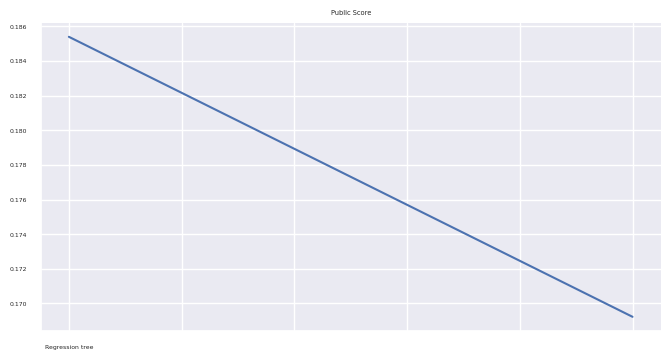

In [174]:
from matplotlib import pyplot as plt
df['Public Score'].plot(kind='line', figsize=(8, 4), title='Public Score')
plt.gca().spines[['top', 'right']].set_visible(False)

## 7. Conclusion

By applying what we have learned about machine learning this semester and experimenting with popular models in the field of machine learning, this project successfully predicted the sales of thousands of Rossmann's stores with a high degree of predictive accuracy. The goal of building a model that can accurately predict sales in Rossmann stores was achieved.